In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics

plt.style.use('seaborn-whitegrid')
sns.set_context('paper') # paper

In [2]:
VARIABLES = [
            'Young', 'Old', 'Male', 'Female', 'Left', 'Right', 'Poor', 'Rich',
        ]
N = len(VARIABLES)

YEARS = range(2016, 2021)

TITLE2PAIR = {
     'Age': ('Young', 'Old'),
     'Gender': ('Male', 'Female'),
     'Affluence': ('Poor', 'Rich'),
     'Leaning': ('Left', 'Right'),
}

In [3]:
PALETTE = sns.color_palette()
COLOR_PAIRS = list(zip(PALETTE[::2], PALETTE[1::2]))

In [4]:
! mkdir -p ../paper/fig

In [5]:
df = pd.read_csv("../data/results/sd-topics-model-regression-topic-results.csv")

df['sign'] = df[['param','signif']].apply(lambda x: np.sign(x[0]) if x[1] else 0, axis=1)

def get_num_signif_years(signs):
    (val,), (cnt,) = scipy.stats.mode(signs)
    return cnt if val != 0 else 0

df_signif_all_years = (df
    .groupby(['topic', 'class']).sign.agg(get_num_signif_years)
    .reset_index()
    .rename(columns={'sign': 'num_signif_years'})
)
df = pd.merge(df, df_signif_all_years)
df

,class,topic,year,param,down_err,up_err,signif,signif01,signif001,sign,num_signif_years
0,Young,BUSINESS,2016,-0.061738,0.042067,0.042067,True,True,True,-1.0,5
1,Young,BUSINESS,2017,-0.101125,0.040138,0.040138,True,True,True,-1.0,5
2,Young,BUSINESS,2018,-0.093715,0.037910,0.037910,True,True,True,-1.0,5
3,Young,BUSINESS,2019,-0.089010,0.052325,0.052325,True,True,True,-1.0,5
4,Young,BUSINESS,2020,-0.029572,0.041092,0.041092,True,False,False,-1.0,5
...,...,...,...,...,...,...,...,...,...,...,...
595,Right,RELIGION,2016,0.043208,0.062338,0.062338,True,False,False,1.0,3
596,Right,RELIGION,2017,-0.041256,0.061675,0.061675,True,False,False,-1.0,3
597,Right,RELIGION,2018,-0.064019,0.067511,0.067511,True,True,False,-1.0,3
598,Right,RELIGION,2019,-0.123640,0.076752,0.076752,True,True,True,-1.0,3


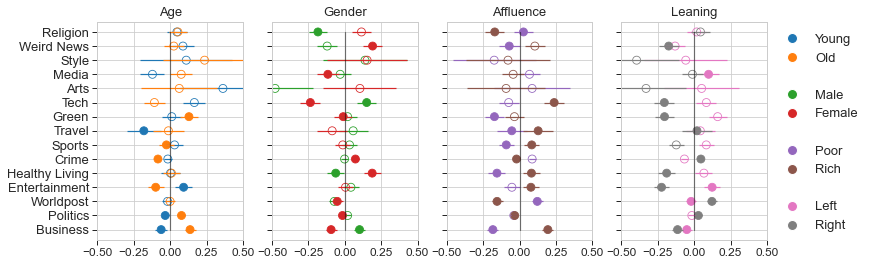

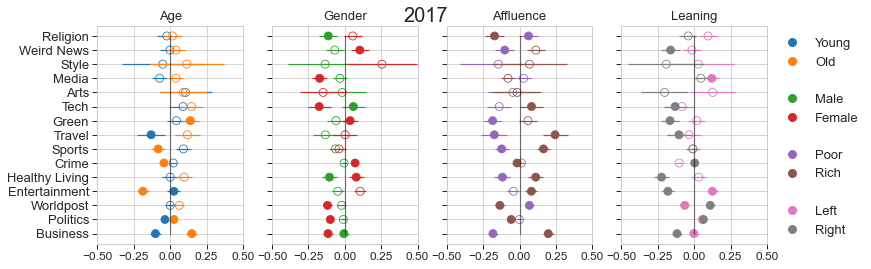

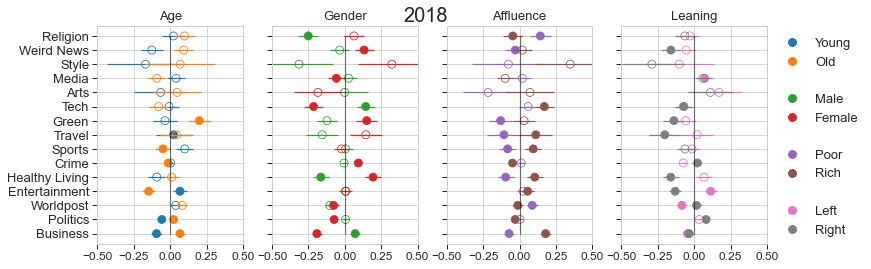

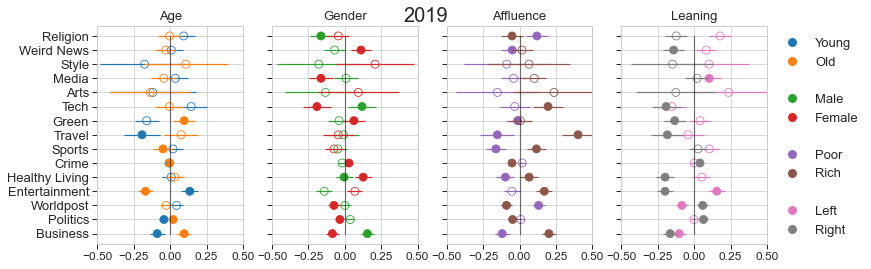

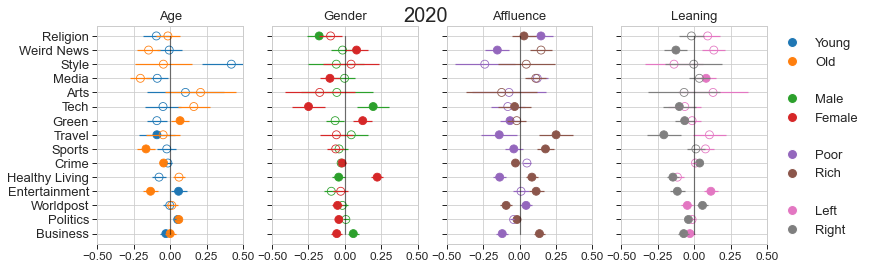

In [6]:
dont_show_year_on = {2016}
selected_topics = df.topic.unique()
topic_labels = [t.title() for t in selected_topics]
for year in [2016, 2017, 2018, 2019, 2020]:
    df_ = df[df.year == year]
    fig, axes = plt.subplots(1, len(TITLE2PAIR), figsize=(12, 4),
                             sharex=True, sharey=True)

    legend = []
    for (title_pair, pair), color_pair, ax in zip(TITLE2PAIR.items(), COLOR_PAIRS, axes):
        for cat, color in zip(pair, color_pair):
            df_cat = df_[df_['class'] == cat]
            assert (df_cat.topic == selected_topics).all()
            params = df_cat.param
            facecolors = (np.abs(df_cat.num_signif_years) >= 4).apply(lambda x:
                            color if x else 'none')

            ax.scatter(params, topic_labels, edgecolors=color, facecolors=facecolors,
                      s=64)
            ax.errorbar(params, topic_labels,
                        xerr=df_cat[['down_err', 'up_err']].values.T,
                        fmt='', linestyle='',
                        color=color)
            legend += [(cat, Line2D([], [], color="white", marker='o',
                                    markerfacecolor=color, markersize=10))]
        legend += [("", Line2D([],[],linestyle=''))]
        ax.plot(np.zeros(len(selected_topics)), topic_labels, alpha=0.5, color='k')
        ax.tick_params(axis='y', which='major', labelsize=13)
        ax.tick_params(axis='x', which='major', labelsize=12)
        ax.set_xlim((-.5, .5))
        ax.set_title(title_pair, fontsize=13)
    
    plt.legend([line for label, line in legend],
               [label for label, line in legend],
               bbox_to_anchor=(1., 1.), fontsize=13)
    if year not in dont_show_year_on:
        ax.text(-2., len(selected_topics), year, fontsize=20)
    for ext in ('pdf', 'png'):
        plt.savefig(f'../paper/fig/plot-topics-news-significance-{year}.{ext}',
                    bbox_inches='tight')
    plt.show()